#DSA 412 Final Project: Solar Energy Curtailment Prediction Using Linear Regression

##By: Matthew Menon




  #    **Introduction**

Solar energy curtailment is an issue in the energy industry where usable solar energy is intentionally wasted in order to prevent overload on the grid. To understand this problem, we need to understand the core causes of solar curtailment. Some core causes are unpredictable weather conditions, the variability of solar generation, and errors in energy forecasting that can lead to unexpected energy demand. Machine learning is used often for predicting renewable energy generation and grid demand already, therefore is a commonly used tool in energy utilities. Specifically, creating a linear regression model using machine learning is a useful tool to solve this problem because there are a lot of different factors that affect solar energy curtailment. With that being said, building a linear regression model using historical data to predict future solar energy curtailment (how much more solar energy was produced than used) is an effective method to work towards quantifying solar energy curtailment. If we discover causal relationships or are able to understand in further depth what factors are most important in predicting future solar energy curtailment, energy providers and utilities can ensure they are not only maximizing revenue off of the energy they produce, but we can also reduce the carbon dioxide emissions into the atmosphere by taking advantage of solar energy produced. To find the appropriate data related to solar energy curtailment, I downloaded the Production and Curtailments .xlsx data files for the years 2023 through 2025 from this link: https://www.caiso.com/about/our-business/managing-the-evolving-grid#renewable-curtailment
    After this, I proceeded to follow the data preprocessing steps below.

  #    **Data Explanation or Exploration**


To begin, we have three excel files from this link: https://www.caiso.com/about/our-business/managing-the-evolving-grid#renewable-curtailment that each contain two sheets with data. First, there is the **production sheet** which contains useful metrics on the energy production within the State of California Indendent System Operator System at 5 minute intervals each day of the year. I am using the three files for the years 2023, 2024, and 2025 for this project in order to collect more recent data.

The columns *Date, Hour, and Interval* are used as indicators of the time in which the observation was captured. The **dates** are normalized in the preprocessing steps below so that the time is not included, as that is captured already in the hour and interval variables and caused issues with combining the excel files. Then, the **hour** variable is an integer 1-24 that represents the hour of the corresponding day shown by the Date variable of which the observation was taken. Within each hour, there is also 12 **intervals** characterized as integers with values 1-12, and they represent the 5 minute intervals of each hour. These variables are crucial in later preprocessing steps when we horizontally merge the two sheets, as these three variables are the common variables between *both the production and curtailments sheets*. Then, the other variables contained only in the production sheet are all measured in megawatts and include **Load**, **Net Load** (load minus solar and wind production), **Solar Production**, **Wind Production**, **Renewable Production** which includes solar, wind, biomass, biogas, geothermal, and small hydropower, **Thermal Production** which represents energy derived from thermal generation processes with the exception of nuclear and geothermal, **Large Hydro Production**, **Imports** entering the CAISO area, and finally **Total Production** which takes into account all internal supply of energy from sources including renewable, large hydro, nuclear, and thermal energy. Finally, the **Load Less** variable is there as a diagnostic to show that generation plus imports is approximately equal to the load.

In the **curtailments sheet**, we have the same *Date, Hour, and Interval* variables as the previous sheet. Additionally, there are Wind Curtailment, Solar Curtailment, and Reason variables. My goal is to horizontally merge these variables with the variables in the **production sheet** for each year from 2023 to 2025 independently, and then vertically merge all these dataframes into one large dataframe. This way, we have many variables as well as solar energy curtailment itself at our disposal to create a linear regression model that can predict solar energy curtailment given these explanatory variables. However, in the **curtailments sheet**, not every hour/interval pair for every date actually has curtailment values reported, which is why I replaced those missing values with zeros after the merging process. This is assuming they are missing because there was no energy curtailed at this time rather than an equipment malfunction.

In [21]:
import pandas as pd

# Read the three Excel files using pd.read_excel
path_to_file1 = "/content/productionandcurtailmentsdata_2023.xlsx"
path_to_file2 = "/content/production-and-curtailments-data-2024.xlsx"
path_to_file3 = "/content/production-and-curtailments-data-2025.xlsx"

# Create dataframes from the three production sheets in each file
energyproduction2023 = pd.read_excel(path_to_file1, engine='openpyxl', sheet_name="Production")
energyproduction2024 = pd.read_excel(path_to_file2, engine='openpyxl', sheet_name="Production")
energyproduction2025 = pd.read_excel(path_to_file3, engine='openpyxl', sheet_name="Production")

# Create dataframes from the three curtailments sheets in each file
energycurtailment2023 = pd.read_excel(path_to_file1, engine='openpyxl', sheet_name="Curtailments")
energycurtailment2024 = pd.read_excel(path_to_file2, engine='openpyxl', sheet_name="Curtailments")
energycurtailment2025 = pd.read_excel(path_to_file3, engine='openpyxl', sheet_name="Curtailments")

# Normalize the dates to remove the irrelevant time information associated with the dates
energycurtailment2023['Date'] = energycurtailment2023['Date'].dt.normalize()
energycurtailment2024['Date'] = energycurtailment2024['Date'].dt.normalize()
energycurtailment2025['Date'] = energycurtailment2025['Date'].dt.normalize()

# Combine the production and curtailment sheets from 2023 to 2025 into one larger dataframe
combined_production = pd.concat([energyproduction2023, energyproduction2024, energyproduction2025], ignore_index=True)
combined_curtailments = pd.concat([energycurtailment2023, energycurtailment2024, energycurtailment2025], ignore_index=True)

# Normalize the dates in these combined dataframes to remove irrelevant time information associated with the dates
combined_production['Date'] = combined_production['Date'].dt.normalize()
combined_curtailments['Date'] = combined_curtailments['Date'].dt.normalize()

# Combine both the production and curtailment data frames from 2023 to 2025 into one large dataframe merged horizontally
# by the date, hour, and interval variables, keeping every observation in the production sheet and leaving missing values
# for the hours and intervals that don't contain curtailment values
combined_all = pd.merge(combined_production, combined_curtailments, on=['Date','Hour','Interval'], how='left').fillna({'Wind Curtailment': 0, 'Solar Curtailment': 0})

In [22]:
combined_all.head()

,Date,Hour,Interval,Load,Solar,Wind,Net Load,Renewables,Nuclear,Large Hydro,Imports,Generation,Thermal,Load Less (Generation+Imports),Wind Curtailment,Solar Curtailment,Reason
0,2023-01-01,1,1,21597.283125,0.0,3444.806442,18152.476683,5031.945557,2244.419769,1489.305664,5893.240000,15702.798424,6937.127435,1.244701,0.0,0.0,NaN
1,2023-01-01,1,2,21524.660938,0.0,3622.804782,17901.856156,5210.076836,2244.401337,1433.653218,5892.720000,15627.185977,6739.054586,4.754961,0.0,0.0,NaN
2,2023-01-01,1,3,21414.377734,0.0,3835.376555,17579.001179,5421.882623,2244.401335,1416.692908,5806.200000,15609.724570,6526.747705,-1.546836,0.0,0.0,NaN
3,2023-01-01,1,4,21325.079063,0.0,4013.220478,17311.858584,5600.721785,2244.771331,1414.016970,5726.560000,15594.241576,6334.731489,4.277487,0.0,0.0,NaN
4,2023-01-01,1,5,21228.566927,0.0,4101.478819,17127.088108,5690.734695,2244.932663,1519.628516,5379.893333,15837.555872,6382.259999,11.117721,0.0,0.0,NaN


In [23]:
combined_all.corr(numeric_only=True)

,Hour,Interval,Load,Solar,Wind,Net Load,Renewables,Nuclear,Large Hydro,Imports,Generation,Thermal,Load Less (Generation+Imports),Wind Curtailment,Solar Curtailment
Hour,1.000000,-0.006100,0.348172,0.067036,0.089350,0.141904,0.087999,0.002933,0.237193,-0.138744,0.361790,0.238533,0.048490,0.042018,0.040956
Interval,-0.006100,1.000000,-0.005557,-0.001431,-0.001695,-0.001891,-0.001817,-0.000190,-0.004822,-0.000895,-0.004054,-0.001098,0.026693,0.000019,0.003539
Load,0.348172,-0.005557,1.000000,0.155799,-0.011061,0.491844,0.161338,0.140916,0.333128,-0.019420,0.825195,0.631094,-0.006879,-0.183332,-0.251411
Solar,0.067036,-0.001431,0.155799,1.000000,-0.164312,-0.762752,0.975501,-0.020836,-0.502619,-0.784883,0.570276,-0.493012,-0.066939,0.202853,0.344559
Wind,0.089350,-0.001695,-0.011061,-0.164312,1.000000,-0.052710,0.055473,0.027788,0.345387,0.038265,-0.030655,-0.187102,0.026076,0.134903,-0.023151
Net Load,0.141904,-0.001891,0.491844,-0.762752,-0.052710,1.000000,-0.779690,0.101846,0.591503,0.680795,0.015862,0.872711,0.050390,-0.322229,-0.461075
Renewables,0.087999,-0.001817,0.161338,0.975501,0.055473,-0.779690,1.000000,-0.008416,-0.424134,-0.788178,0.576639,-0.536319,-0.061836,0.233228,0.340997
Nuclear,0.002933,-0.000190,0.140916,-0.020836,0.027788,0.101846,-0.008416,1.000000,0.036617,0.045245,0.089183,0.019345,-0.002139,-0.018966,-0.037441
Large Hydro,0.237193,-0.004822,0.333128,-0.502619,0.345387,0.591503,-0.424134,0.036617,1.000000,0.356166,0.070014,0.389462,0.036301,-0.160488,-0.261731
Imports,-0.138744,-0.000895,-0.019420,-0.784883,0.038265,0.680795,-0.788178,0.045245,0.356166,1.000000,-0.580766,0.272780,0.086338,-0.263359,-0.378096


  #    **Algorithms and Techniques Analysis**


Now that the preprocessing stages are complete and I have a large dataset I am happy with, I created a correlation matrix of all the numeric variables seen above. In solar energy curtailment prediction using a machine learning approach, there are two common methods of prediction. These are linear regression models and logistic regression models. In a logistic regression model, the model will predict *whether or not* solar energy curtailment would occur given the feature values as a binary output (yes/no). In a linear regression model, which is what I am producing, the model aims to provide an estiamte as to how much solar energy will be curtailed given feature values. These are both useful models to energy utilities in order to maximize the use of the energy they produce, however the linear regression model is significantly harder to make accurate when compared to the logistic regression model. This is due to most solar energy curtailment values being 0 given that there are many 5 minute intervals from 2023 to 2025, most of these time intervals saw zero solar energy curtailed. However, some of the intervals that did see solar energy curtailment had values in thousands of megawatts. This presents challenges in linear regression models that do not want to estimate 0 energy curtailment even when that would be considered an accurate prediction for most 5-minute time intervals.

Below, I choose the features I want to include in my model.

In [78]:
model1Features = ['Hour','Load','Solar','Wind','Nuclear']
model1AllVariables = ['Hour','Load','Solar','Wind','Nuclear','Solar Curtailment']

In [79]:
combined_all[model1AllVariables].corr()

,Hour,Load,Solar,Wind,Nuclear,Solar Curtailment
Hour,1.000000,0.348172,0.067036,0.089350,0.002933,0.040956
Load,0.348172,1.000000,0.155799,-0.011061,0.140916,-0.251411
Solar,0.067036,0.155799,1.000000,-0.164312,-0.020836,0.344559
Wind,0.089350,-0.011061,-0.164312,1.000000,0.027788,-0.023151
Nuclear,0.002933,0.140916,-0.020836,0.027788,1.000000,-0.037441
Solar Curtailment,0.040956,-0.251411,0.344559,-0.023151,-0.037441,1.000000


This smaller correlation matrix is useful in showing the correlations for the specific features I plan to use in my model. It is apparent that most all of the correlations are fairly small, meaning there shouldn't be much multicollinearity present in regards to high correlation between features. After consulting with Dr. Harrison Fell from the Agriculture and Resource Economics Department at NC State, these are the features we decided were important for predicting solar energy curtailment:

**Hour**: From the early morning to the mid afternoon and even the middle of the night, solar energy curtailment depends heavily on the hour of the day. Of course, solar energy is only being generated when the Sun is up, and the changes in energy demand that can result in solar energy being curtailed are highly dependent on the hour.

**Load**: Load, or equivalently energy demand, is extremely important in predicting solar energy curtailment. The load is the driving force between all energy production in the first place, and energy is produced in various quantities by various sources in order to meet peak energy demand. However, sometimes load may be lower than predicted, in which case solar energy can be curtailed. On the flip side, sometimes load is far higher than expected, in which case the grid can become congested and solar energy curtailment can also result.

**Solar**: Solar generation is important in the prediction of solar energy curtailment because knowing how much solar energy is actually being generated at a given point in time affects the probability and quantity in which it will be curtailed. The more solar energy being produced in low demand time periods, the higher chance it will be curtailed if not exported or stored.

**Wind**: A common substitute for solar energy, both wind and solar are the first to be used in energy production due to their effectively non-existent marginal cost to operate. When wind energy production is especially high, there may be times where this is substituted for solar leading to solar energy curtailment. (Note: Wind energy curtailment is another issue when wind energy is produced but not utilized)

**Nuclear**: Nuclear energy production is valuable in predicting solar energy curtailment due to it's inability to be shut off. Once a nuclear power plant is built, it continues to run for its entire lifetime unlike other energy sources such as hydropower which is only switched on under specific circumstances. This means, when nuclear energy production is high, it may result in solar energy being curtailed.

**Solar Curtailment**: This is the variable to be predicted, and it represents the amount of megawatts of solar energy produced by utilities such as CAISO, and then subsequently wasted due to a variety of factors.

--------------------------------------------------------------------------------

There were also other variables that I was recommended to utilize but did not due to complications in creating a larger dataset with them:

**Exports**: Energy exports is a common strategy used to combat curtailment. When extra wind or solar energy is produced by a utility, a strategy to mitigate this extra energy and still make money off of it is to export it to other regions that can utilize it. Exports would be important to take into consideration since it means energy that the model may think is being curtailed may actually be exported instead in reality.

**Battery Charge/Discharge**: Another alternative to curtailing energy is to utilize it to charge batteries for later use. This is commonly used especially in the state of California in order to preserve this produced energy for later use, therefore not curtailing it.

**Solar Irradiance**: Solar irradiance is an important factor that allows us to determine how much solar energy can be produced at a given time due to the amount of energy reaching land from the Sun. The challenge with implementing solar irradiance data into the curtailment model is that solar irradiance is location-specific, meaning I would have to consider the location of curtailment rather than curtailment as a whole. This is because a single solar irradiance value for the entire state of California is not realistic, and solar irradiance varies greatly as location changes.

  #    **Visualization**

Next, I created a visualization using seaborn in order to map out the distributions of all the features in relation to eachother to get a sense of any patterns that may exist. This is another important step in addressing multicollinearity due to high correlations between features, and this step serves as a benchmark to identify these issues early if they are present.

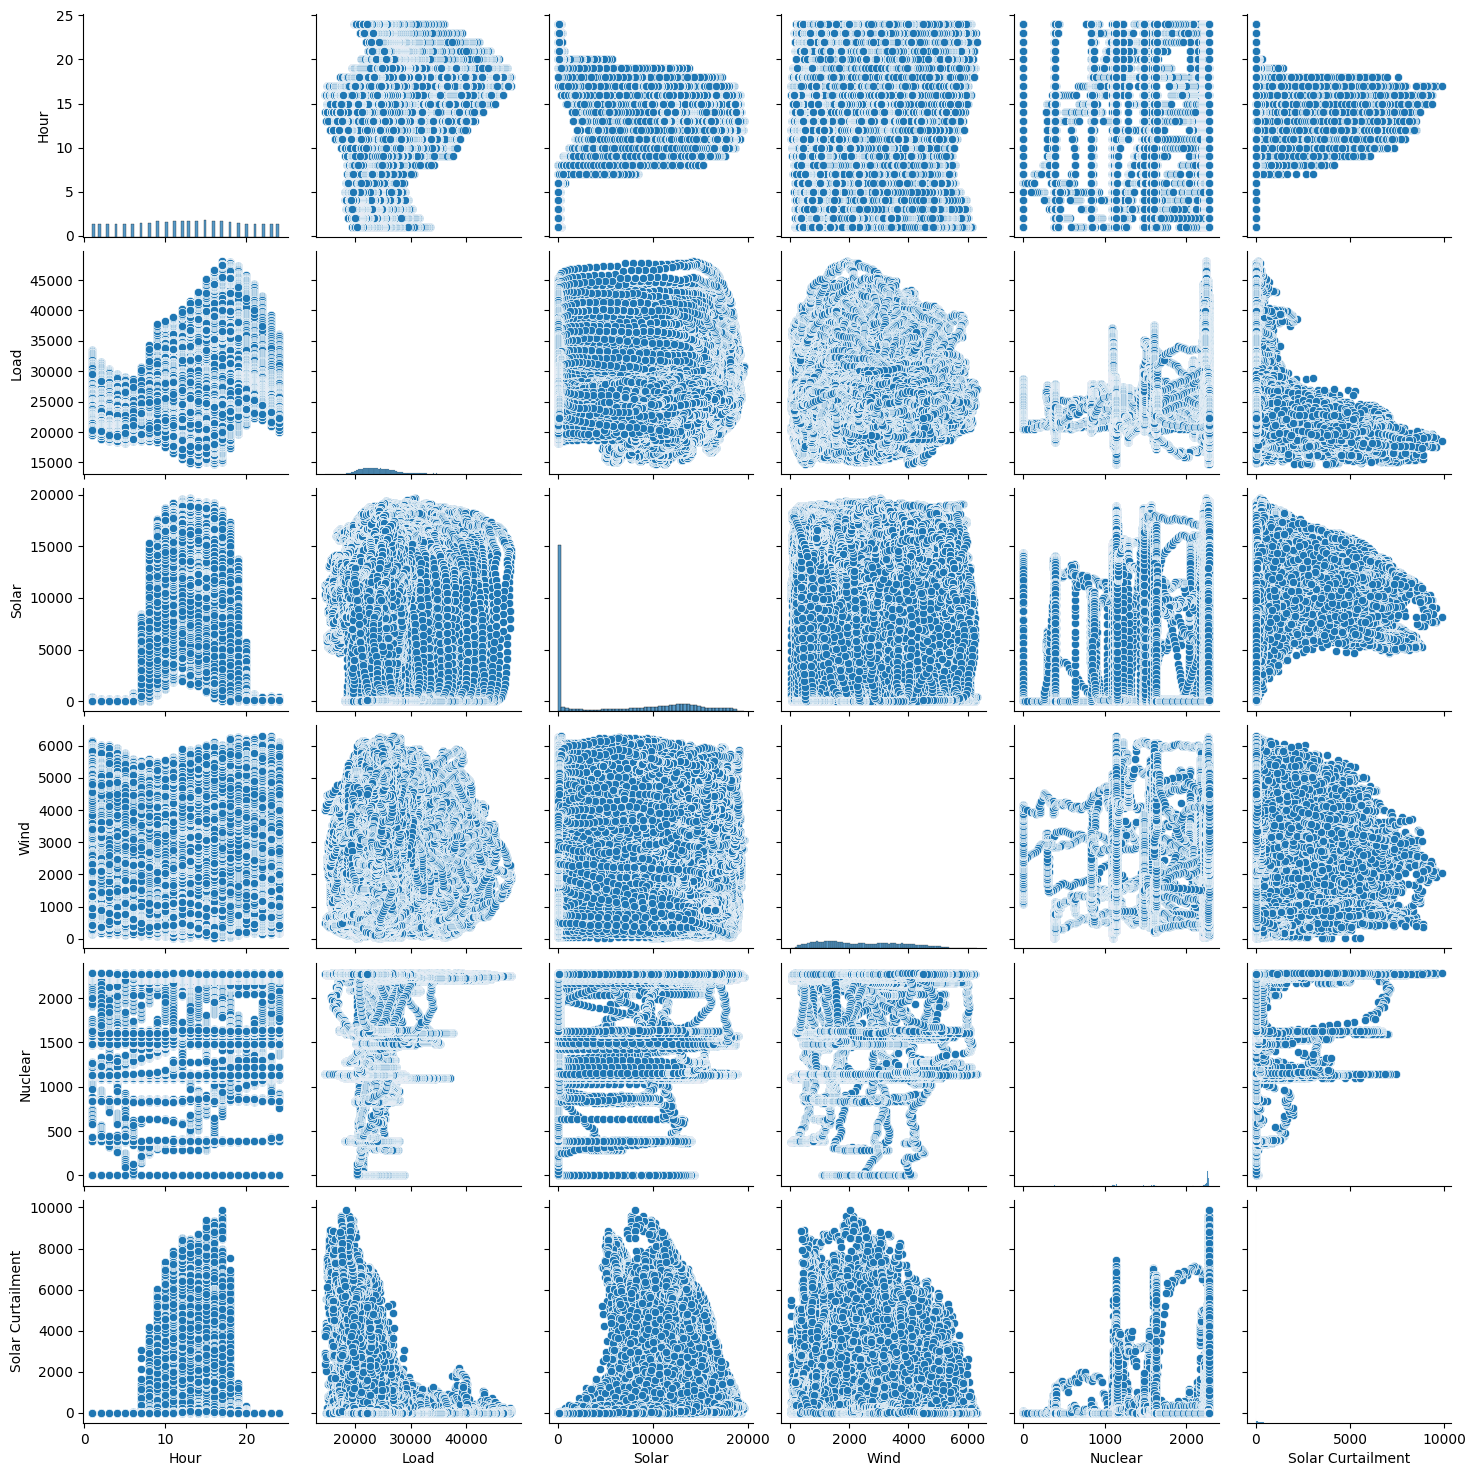

In [80]:
import seaborn as sns

sns.pairplot(combined_all[model1AllVariables])

Observing the visualizations above, my goal is to observe any obvious patterns between features. Many appear quite randomly distributed, with some distributions having a normal shape to them. Since this is a linear regression model, my main concern would be if any of the features have an obvious linear relationship to them. From the plots above, it does not appear that is the case for most of the features, which allows me to feel confident in moving forward to the model building itself.

In [81]:
X1 = combined_all[model1Features].values
y1 = combined_all['Solar Curtailment'].values
X2 = combined_all[model1Features].values
y2 = combined_all['Solar Curtailment'].values

In this case, I have chosen to split the test data so that the test_size is 0.33 or 33 percent of the data. Then, I again refer back to the consulting I received from Dr. Fell in my model selection. When approaching him about this project, the machine learning methods he recommended to me were a simple Ordinary Least Squares (OLS) model, a Least Absolute Shrinkage and Selection Operator (LASSO) model, and random forests. This is why I created two models below using the same features from above. The first is an OLS model, with it's use stemming from the fact that this model aims to minimize the sum of the squared differences between observed and predicted values. Then a slightly more sophisticated approach comes from the LASSO model, where this model has the additional functionality of shrinking the coefficients of certain features to zero that it deems not useful in predicting the variable of interest. This is important in preventing overfitting. The last machine learning method I could've used but did not was the random forest method of feature selection, however this would be an interesting way to further develop the premise of predicting solar energy curtailment. This machine learning method creates many different decision trees based on random selection of features and data, which can drastically reduce overfitting if performed correctly.

In [82]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size = 0.33, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size = 0.33, random_state = 42)

In [83]:
from sklearn.linear_model import LinearRegression, Lasso
lin_reg_model1 = LinearRegression().fit(X1,y1)
lin_reg_model2 = Lasso().fit(X2,y2)

**Derive Coefficients for the Models**

In [84]:
lin_reg_model1.coef_

array([ 1.97254129e+01, -7.61305418e-02,  5.83991080e-02,  1.70644328e-02,
        4.83616046e-02])

In [85]:
lin_reg_model2.coef_

array([ 1.96995730e+01, -7.61171117e-02,  5.83998266e-02,  1.70762765e-02,
        4.83353187e-02])

**Use Training Data to Predict Test Values**

In [86]:
#predict the values for model 1
y1_test_predict_vals = lin_reg_model1.predict(X1_test)

In [87]:
#predict the values for model 2
y2_test_predict_vals = lin_reg_model2.predict(X2_test)

**Calculate Mean Squared Error of Both Models**

In [88]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y1_test, y1_test_predict_vals)

711295.2025995691

In [89]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y2_test, y2_test_predict_vals)

711296.383001229

Unfortunately, we notice the mean squared error is quite high for both models. However, it is important to note this is the mean *squared* error, and therefore the units are in megawatts squared rather than megawatts. Taking the square root of both values yields approximately 843 megawatts. In this case, the range of solar energy curtailment must be taken into account, as although a majority of solar energy curtailment values were zero in this data due to the 5-minute intervals, the solar energy curtailment values that were greater than zero were fairly large, with an overall mean of 333 Megawatts and a maximum solar energy curtailment value of a whopping 9,883 Megawatts.

  #    **Conclusion**

Both models predict solar energy curtailment about as accurately as you would expect given the low number of features and overall simplicity of the model. A more robust model would include many more features related to location, grid status, weather conditions, and more. Additionally, the way solar energy curtailment is distributed is unique considering the amount of observations in which the solar energy curtailed is zero, with other observations reaching close to 10,000 Megawatts. In future models, it may be helpful to consider a transformation of these types of variables, such as a log transform to reduce the distances between values while preserving the relationship between them. Additionally, although the MSE values for both models are almost exactly the same, it is interesting that the LASSO model has almost the same MSE as the OLS model despite it's additional ability to reduce overfitting.

In terms of the model's results, while the MSE is still quite large, Root Mean Squared Error (RMSE) is only about 500 Megawatts greater than the mean of the solar energy curtailed, which is significant considering most of the solar energy curtailment values are zero. This means while there may be room for improvement, the model itself is a solid start to predicting solar energy curtailment. Additionally, most of the coefficients for the features are quite small, and I would be interested to learn more about why that is. I would also be interested to know what the accuracy of a model utilizing a random forest method and more features that have the potential to predict solar energy curtailment would be. Are there any other linear regression models or transformations that can be done on the existing variables to yield a more accurate model?

An important step in mitigating the effects of climate change is by addressing how we receive the energy in which we use every day. What are other issues besides energy curtailment that energy utilities are attempting to address that can lead to positive outcomes in sustainable energy consumption? As machine learning continues to grow and evolve, will it be useful in these cases as well? Only time will tell, however the important role machine learning and data science play in the energy sector will remain cemented as models such as these continue to be developed to allow Independent System Operators such as CAISO to optimize energy production and consumption.